## CS156 Assignment 5 - Yosemite Village yearly weather

In [1]:
#importing the necessary libraries
import GPy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from datetime import datetime
import pandas as pd
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import metrics
from datetime import datetime
from mpl_toolkits.mplot3d.axes3d import Axes3D
import random
from sklearn.model_selection import train_test_split
GPy.plotting.change_plotting_library('matplotlib')
import time
%matplotlib notebook 


## Data Analysis
I first start by cleaning the data and turning it into the form (day, time) as mentioned in the assignment instructions.

In [2]:
years = range(2011, 2017) # all the 6 years
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years] #names of the files that contain data
columns = [1, 2, 8] #the columns we need: 1: date, 2: time of day, 8: temperature

### Loading the data for the six years using the specific columns mentioned in the cell above:

In [3]:
year_1 = np.loadtxt(files[0], usecols=columns)
#
year_2 = np.loadtxt(files[1], usecols=columns)
#
year_3 = np.loadtxt(files[2], usecols=columns)
#
year_4 = np.loadtxt(files[3], usecols=columns)
#
year_5 = np.loadtxt(files[4], usecols=columns)
#
year_6 = np.loadtxt(files[5], usecols=columns)

#### The time of the data is given in the form HHmm (HourHourminutesminutes), I convert it to minutes at 5 minutes step using the formula: **int((time)/100) * 60 + time%100**. Also, the missing data has values -1000 for temperature, I delete them here:

In [4]:
year_1[:, 1] = np.floor_divide(year_1[:, 1], 100) * 60 + np.mod(year_1[:, 1], 100)
year_1 = year_1[year_1[:, 2] > -1000] 

year_2[:, 1] = np.floor_divide(year_2[:, 1], 100) * 60 + np.mod(year_2[:, 1], 100)
year_2 = year_2[year_2[:, 2] > -1000] 

year_3[:, 1] = np.floor_divide(year_3[:, 1], 100) * 60 + np.mod(year_3[:, 1], 100)
year_3 = year_3[year_3[:, 2] > -1000] 

year_4[:, 1] = np.floor_divide(year_4[:, 1], 100) * 60 + np.mod(year_4[:, 1], 100)
year_4 = year_4[year_4[:, 2] > -1000]  

year_5[:, 1] = np.floor_divide(year_5[:, 1], 100) * 60 + np.mod(year_5[:, 1], 100)
year_5 = year_5[year_5[:, 2] > -1000] 

year_6[:, 1] = np.floor_divide(year_6[:, 1], 100) * 60 + np.mod(year_6[:, 1], 100)
year_6 = year_6[year_6[:, 2] > -1000]  

### Now, I put the training data together (the first five years) and test data will be year 6:

In [5]:
# train data:
train_years = [year_1, year_2, year_3, year_4, year_5]
all_data_train = np.concatenate(train_years)

# test data:
all_data_test = year_6

### I will get the full date just for reference

In [6]:
full_date = [] 
for s in all_data_train[:, 0]:
    s = str(s) # date as integer in the format "YearMonthDay"
    # the following line will take that string and put it in the form year-month-day
    full_date.append(str(datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8])).date()))

### Now, I will build a dataset that has which day of the year each date refers to and which time of the day it refers to

In [7]:
# get the day of the year:
train_day_of_year = []

## For train data:
for year in train_years:
    for s in year[:, 0]:
        # putting the date in the datetime string form as mentioned above:
        s = str(s)   
        my_date = datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8])).date()
        day = my_date.timetuple().tm_yday # this is a method in Python's datetime module that returns
        #which day of the year that date refers to
        train_day_of_year.append(day)
        
## For test data: Doing the same for the test data
test_day_of_year = []
for s in all_data_test[:, 0]:
    s = str(s)   
    my_date = datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8])).date()
    day = my_date.timetuple().tm_yday
    test_day_of_year.append(day)
    

#time of the day:
# for train
train_time_of_day = all_data_train[:, 1] #in minutes
train_temperature = all_data_train[:, 2]

# For test:
test_time_of_day = all_data_test[:, 1] #in minutes
test_temperature = all_data_test[:, 2]


In [8]:
# finally, building the dataset:
train_DataFrame = pd.DataFrame({"Full Date": full_date,"Day Of the Year":train_day_of_year, 
                                "Minutes of the Day": train_time_of_day, "Temperature": train_temperature})
train_DataFrame

,Full Date,Day Of the Year,Minutes of the Day,Temperature
0,2011-01-01,1,5.0,-6.4
1,2011-01-01,1,10.0,-6.5
2,2011-01-01,1,15.0,-6.5
3,2011-01-01,1,20.0,-6.5
4,2011-01-01,1,25.0,-6.7
...,...,...,...,...
525475,2015-12-31,365,1420.0,-1.4
525476,2015-12-31,365,1425.0,-1.6
525477,2015-12-31,365,1430.0,-1.4
525478,2015-12-31,365,1435.0,-1.6


### I have tried to build a model with all the data but I ran out of memory (even when I used one inducing point). So I decided to take a subset of the data.

In [9]:
train_sample = train_DataFrame.sample(10000) #taking a random sample of the data

### After I splitted the data into two components, I'm going to fit a 2D sparse GP to both components simultaneously. This way, I will be able to model the interaction between the time of day and day of year components and the model will capture more of the variation. 

### Since I plan to model the temperature over time of day and temperature over time of year, then I don't want to fit each year individually but fit the temperature for all years so I need the model to predect the average temp for a given time during a new year. For that reason, I plan to use RBF, which is a kernel function that returns a measure of similarity between two sets of features. RBF should be able to model the average temp for all years since it's suitable for modeling smooth functions and it's more flexible than many other kernels. The kernel has two main hyperparamters: 
### - The lengthscale is a hyperparamter in RBF that describes how close two points have to be so that they influence eachother signficantly. This length scale affects the covariacne of the matrix because it determines how large or small the covariacne of two variables is (based on how close they are). This paramter affects the smoothness of a kernel and then it affects how smooth the functin output is.
### - The variance which determines the spread of the kernel. 

### To reach the optimal values of these hyperparamters, I will use the optimize method of GP. This method reaches the optimal values for the hyperparamters by maximizing the log likelihood function.

### In order to find the best number of inducing points, I will split my training data into train and validation and then I will train a model with different values of inducing points and each time, I will check the MSE on the validation dataset. I will choose the number of inducing points that gives the minimum MSE on the validation.



In [10]:
#split the training data into train and validation:
subtrain, validation = train_test_split(train_sample, test_size=0.2)

In [11]:
_2d_subtrain_x = np.array(subtrain[['Day Of the Year', 'Minutes of the Day']])
_2d_subtrain_y = np.array(subtrain['Temperature']).reshape(-1, 1)
###
_2d_validation_x = np.array(validation[['Day Of the Year', 'Minutes of the Day']])
_2d_validation_y = np.array(validation['Temperature']).reshape(-1, 1)

### I ran the following cell with different number of inducing points until I reached the number that gave the best MSE on the validation set (2000), any values larger than 2000 didn't improve MSE.

In [12]:
kernel = GPy.kern.RBF(input_dim=2)
_2d_model = GPy.models.SparseGPRegression(_2d_subtrain_x,_2d_subtrain_y,kernel, num_inducing = 2000)
_2d_model.optimize()

predict_subtrain = _2d_model.predict(_2d_subtrain_x)[0]
predict_validation = _2d_model.predict(_2d_validation_x)[0]

print(f"mse on train: {metrics.mean_squared_error(_2d_subtrain_y, predict_subtrain)}")
print(f"mse on validation: {metrics.mean_squared_error(_2d_validation_y, predict_validation)}")

mse on train: 23.602601970028136
mse on validation: 24.310506758855176


### After I found the best number of inducing points, I'm going to train my model again on all the training data (train+validation)

In [13]:
_2d_train_x = np.array(train_sample[['Day Of the Year', 'Minutes of the Day']])
_2d_train_y = np.array(train_sample['Temperature']).reshape(-1, 1)

In [14]:
GP_before = time.time() #measuring the training time
kernel = GPy.kern.RBF(input_dim=2)
_2d_model = GPy.models.SparseGPRegression(_2d_train_x,_2d_train_y,kernel, num_inducing = 2000)
_2d_model.optimize()
GP_after = time.time()
print("Time taken:", GP_after - GP_before)

Time taken: 707.4643857479095


In [15]:
# preparing the test data for the model
test_day_of_year = np.array(test_day_of_year).reshape(-1, 1)
test_time_of_day = test_time_of_day.reshape(-1, 1)
_2d_test_x = np.concatenate([test_day_of_year, test_time_of_day], axis=1)
_2d_test_y = test_temperature

In [16]:
predict_train = _2d_model.predict(_2d_train_x)[0]
predict_test = _2d_model.predict(_2d_test_x)[0]
print(f"mse on train: {metrics.mean_squared_error(_2d_train_y, predict_train)}")
print(f"mse on test: {metrics.mean_squared_error(_2d_test_y, predict_test)}")

mse on train: 23.69098184698246
mse on test: 22.81965185471137


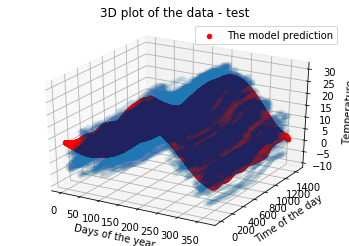

In [17]:
#plotting a 3d model of my prediction
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(_2d_test_x[:, 0], _2d_test_x[:, 1], _2d_test_y, alpha = .01)
ax.scatter(_2d_test_x[:, 0], _2d_test_x[:, 1], predict_test, color = 'red', 
           label = 'The model prediction')

ax.set_xlabel('Days of the year')
ax.set_ylabel('Time of the day')
ax.set_zlabel('Temperature')
plt.title("3D plot of the data - test", y=1.08)
plt.legend()
plt.show()

### Copying the model from the last assignment:

In [18]:
# The yearly component of the data:

linear_time_before = time.time()
# For train_data
RBFs_number = 16

# These are the centers for the RBFs. I will have 16 centers that are equally distributed between
# the minimum value of the day of the year (which is 1) and the maximum value (which is 365):

train_day_of_year_centers = np.array([i for i in range(int(min(_2d_train_x[:, 0]))
                                                       ,int(max(_2d_train_x[:, 0]))
                                                       ,int(max(_2d_train_x[:, 0])-min(_2d_train_x[:, 0])) \
                                                       //RBFs_number)]).reshape(-1, 1)

sigma = 81000 #width of RBFs

# mapping to the RBFs:
train_day_of_year_kernel = rbf_kernel(_2d_train_x[:, 0].reshape(-1, 1), train_day_of_year_centers, gamma=1 / sigma)


######## Doing the same for the test data:

# For test_data:
RBFs_number = 16
test_day_of_year_centers = np.array([i for i in range(int(min(_2d_test_x[:, 0]))
                                                       ,int(max(_2d_test_x[:, 0]))
                                                       ,int(max(_2d_test_x[:, 0])-min(_2d_test_x[:, 0])) \
                                                       //RBFs_number)]).reshape(-1, 1)
sigma = 81000
test_day_of_year_kernel = rbf_kernel(_2d_test_x[:, 0].reshape(-1, 1), test_day_of_year_centers, gamma=1 / sigma)

####
# The daily component of the data:

# For train data:
RBFs_number = 16
train_time_of_day_centers = np.array([i for i in range(int(min(_2d_train_x[:, 1]))
                                                       ,int(max(_2d_train_x[:, 1]))
                                                       ,int(max(_2d_train_x[:, 1])-min(_2d_train_x[:, 1])) \
                                                       //RBFs_number)]).reshape(-1, 1)
sigma = 8000
train_time_of_day_kernel = rbf_kernel(_2d_train_x[:, 1].reshape(-1, 1), train_time_of_day_centers, gamma=1 / sigma)



#######
# For test data:
RBFs_number = 16
test_time_of_day_centers = np.array([i for i in range(int(min(_2d_test_x[:, 1]))
                                                       ,int(max(_2d_test_x[:, 1]))
                                                       ,int(max(_2d_test_x[:, 1])-min(_2d_test_x[:, 1])) \
                                                       //RBFs_number)]).reshape(-1, 1)
sigma = 8000
test_time_of_day_kernel = rbf_kernel(_2d_test_x[:, 1].reshape(-1, 1), test_time_of_day_centers, gamma=1 / sigma)

####
# Merging the two componenets:
train_two_components_kernel = np.concatenate((train_day_of_year_kernel, train_time_of_day_kernel), axis=1)
test_two_components_kernel = np.concatenate((test_day_of_year_kernel, test_time_of_day_kernel), axis=1)


In [19]:
# Training the model using the two components of the data:

model_linear_two_components = linear_model.LinearRegression()
model_linear_two_components.fit(train_two_components_kernel, _2d_train_y)
linear_time_after = time.time()

predict_y_train_two_components = model_linear_two_components.predict(train_two_components_kernel)
predict_y_test_two_components = model_linear_two_components.predict(test_two_components_kernel)

print("Training time:", linear_time_after-linear_time_before )
print(f"MAE on train: {metrics.mean_squared_error(_2d_train_y, predict_y_train_two_components)}")
print(f"MAE on test: {metrics.mean_squared_error(_2d_test_y, predict_y_test_two_components)}")

Training time: 0.3031890392303467
MAE on train: 23.96647350663857
MAE on test: 23.579705181930752


### Conclusion
The MSE of the two models on the test dataset were close (GP:22.81, Linear:23.58) because the two models use the same RBF kernel. GP had a slighlty better performance because it managed to model the interaction between the time of day and day of year components and then it captured more variation but the linear model modeled each of them individually. 

The GP model took much more time (707 seconds). This is expected since GP builds a multivariate gaussian distribution of 10000 dimensions (the number of points I used) and for this reason GP has memory and time constraint as it becomes very hard to use it on a large dataset (I wasn't able to fit the model to all the 500,000 data points that I had because that would require building a multivariate normal distribution of 500,000 dimensions).